In [1]:
import keras

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Concatenate, Dropout
from keras.models import Model

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16765460960785619252
]


In [2]:
from ast import literal_eval
# data_train = pd.read_pickle('drive/My Drive/Colab Notebooks/fakenews-master/data/news_proc_12_3_19.pickle')
data_train = pd.read_csv('C:\\Users\\91998\\Downloads\\FInal Code\\train.csv')
data_train = data_train[['label', 'text', 'title']]
data_train['label'].unique()

array([1, 0], dtype=int64)

In [3]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [7]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [6]:
from ast import literal_eval
data_train = pd.read_csv('C:\\Users\\91998\\Downloads\\FInal Code\\train.csv')
data_train = data_train[['label', 'text', 'title']]
data_train['label'].unique()

array([1, 0], dtype=int64)

In [8]:
data_train['label'] = data_train['label'].replace('fake',1)
data_train['label'] = data_train['label'].replace('real',0)

In [9]:
texts = []
labels = []

for i in range(data_train.text.shape[0]):
    text1 = data_train.title[i]
    text2 = data_train.text[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(data_train.label[i])

In [10]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 251876 unique tokens.


In [11]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (20800, 1000)
Shape of label tensor: (20800, 2)


In [12]:
# Train test validation Split
from sklearn.model_selection import train_test_split
print(type(data))
indices = np.arange(len(data))
print(indices)
np.random.shuffle(indices)
l = []
d = []
for each in indices:
  d.append(data[each])
  l.append(labels[each])
data =np.asarray(d)
labels = np.asarray(l)
print(type(data[0]))
x_train, x_test, y_train, y_test = train_test_split( data, labels, test_size=0.20, random_state=42)
x_test, x_val, y_test, y_val = train_test_split( data, labels, test_size=0.50, random_state=42)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))




<class 'numpy.ndarray'>
[    0     1     2 ... 20797 20798 20799]
<class 'numpy.ndarray'>
Size of train, validation, test: 16640 10400 10400


In [13]:
GLOVE_DIR = "C:\\Users\\91998\\Downloads\\FInal Code\\"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [17]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [18]:
params_lstm = {
    'lr': 0.2639850638741692,
    'momentum': 0.08255873365806747,
    'dropout': 0.10591561319817788,
    'dense1': 73,
    'dense2': 24,
    'lstmTitle': 46,
    'lstmContent': 231
}

In [19]:
from tensorflow import keras as k
import tensorflow as tf
#input_title
input = k.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='input')
inp = k.layers.Embedding(output_dim=EMBEDDING_DIM, input_dim=251877, 
                         weights=[embedding_matrix], trainable=False)(input)
x = k.layers.Bidirectional(k.layers.LSTM(params_lstm['lstmTitle']))(inp)
#CudnnLSTM
#x = k.layers.Bidirectional(k.layers.CuDNNLSTM(params_lstm['lstmTitle']))(inp)

# #input_content
# content_input = k.layers.Input(shape=(len_content,), name='content_input')
# inp2 = k.layers.Embedding(output_dim=300, input_dim=50000, 
#                          weights=[embed_mat], trainable=False)(content_input)
# x2 = k.layers.Bidirectional(k.layers.LSTM(params_lstm['lstmContent']))(inp2)
# #CudnnLSTM
# #x2 = k.layers.Bidirectional(k.layers.CuDNNLSTM(params_lstm['lstmContent']))(inp2)

# #Merge
# x = k.layers.concatenate([x, x2])


#Common part
x = k.layers.Dense(params_lstm['dense1'], activation='relu')(x)
x = k.layers.Dropout(params_lstm['dropout'])(x)
x = k.layers.Dense(params_lstm['dense2'], activation='relu')(x)
x = k.layers.Dropout(0.2)(x)

out = k.layers.Dense(2, activation='sigmoid')(x)

#Build model
model = k.models.Model(inputs=[input], outputs=[out])

model.compile(k.optimizers.SGD(lr=params_lstm['lr'], 
                              momentum=params_lstm['momentum']), 
                              loss='categorical_crossentropy', metrics=['acc'])

# model.compile(tf.train.MomentumOptimizer(learning_rate=params_lstm['lr'], 
#                                          momentum=params_lstm['momentum']), 
#                                          loss='binary_crossentropy', metrics=['acc'])

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1000)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         25187700  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 92)                54096     
_________________________________________________________________
dense_3 (Dense)              (None, 73)                6789      
_________________________________________________________________
dropout_2 (Dropout)          (None, 73)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1776      
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0   

In [22]:
 history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Train on 16640 samples, validate on 10400 samples
Epoch 1/3
16640/16640 [==============================] - 2059s 124ms/sample - loss: 0.3587 - acc: 0.8390 - val_loss: 0.3627 - val_acc: 0.8488
Epoch 2/3
16640/16640 [==============================] - 2413s 145ms/sample - loss: 0.2520 - acc: 0.8988 - val_loss: 0.1877 - val_acc: 0.9267
Epoch 3/3
16640/16640 [==============================] - 2422s 146ms/sample - loss: 0.1977 - acc: 0.9264 - val_loss: 0.1666 - val_acc: 0.9349


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


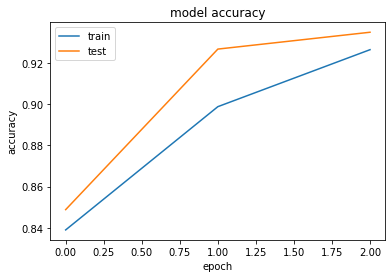

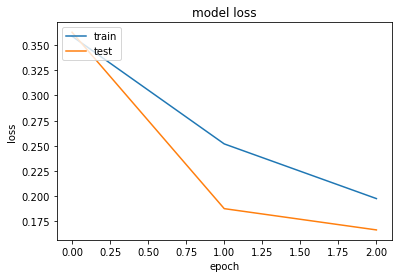

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline 
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
# plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
# plt.title('Confusion matrix - model1')
# plt.colorbar()
# plt.ylabel('expected label')
# plt.xlabel('predicted label')
# plt.show()
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size

Correct predictions: 9783.0
Total number of test examples: 10400
Accuracy of model1:  0.9406730769230769


NameError: name 'modell' is not defined